In [1]:
%matplotlib inline

import matplotlib
import requests
import random
import urllib.parse
from tqdm import tqdm
from time import sleep
import pandas as pd

In [2]:
df = pd.read_csv("input/NER_results.csv", header='infer')
columns = ['Start_index', 'End_index', 'description', 'transcriber name', 'transcript status', 'title', 'date']
df.drop(columns, inplace=True, axis=1)
df = df.rename(columns={'Entities': 'entity', 'Label': 'entity_type', 'Doc_ID': 'doc_id'})
df.head()

,entity,entity_type,doc_id
0,police athletic league,ORG,RG_9_8_110
1,new york city,GPE,RG_9_8_110
2,connie ford,PERSON,RG_9_8_110
3,pal,ORG,RG_9_8_110
4,soul of reason,WORK_OF_ART,RG_9_8_110


In [3]:
len(df)

6800

In [4]:
df['frequency'] = df['entity'].map(df['entity'].value_counts())
df = df.groupby(['entity','entity_type','frequency'])['doc_id'].apply(list).reset_index()
df = df.sort_values(by=['frequency'], ascending=False)
df.head()

,entity,entity_type,frequency,doc_id
1745,soul of reason,WORK_OF_ART,324,"[RG_9_8_110, RG_9_8_110, RG_9_8_110, RG_9_8_11..."
1420,new york university,ORG,193,"[RG_9_8_110, RG_9_8_110, RG_9_8_42, RG_9_8_42,..."
1419,new york university,FAC,193,[RG_9_8_52]
1398,new york,GPE,176,"[RG_9_8_110, RG_9_8_110, RG_9_8_42, RG_9_8_42,..."
1399,new york,ORG,176,[RG_9_8_187]


In [5]:
len(df)

2467

In [6]:
df.to_csv('results/frequecy_sorted_entities.csv', encoding='utf-8', index=False)

In [7]:
uri_prefix = "https://wikidata.reconci.link/en/api?queries="
match_ids = []
match_names = []
match_scores = []

In [8]:
for i in tqdm(range(len(df))):
    n = random.uniform(0, 0.17)
    sleep(n)
    item = df.iloc[i]
    request = uri_prefix + urllib.parse.quote_plus('{"q1": {"query": "' + item['entity'] + '"}}')
    response = requests.get(request).json().get('q1').get('result')
    if response:
        match = response[0]
        match_ids.append(match.get('id', None))
        match_names.append(match.get('name', None)) 
        match_scores.append(match.get('score', None))
    else:
        match_ids.append(None)
        match_names.append(None)
        match_scores.append(None)

100%|██████████| 2467/2467 [2:05:10<00:00,  3.04s/it]   


In [9]:
df['match_id'] = match_ids
df['match_name'] = match_names
df['match_score'] = match_scores

In [10]:
df.head()

,entity,entity_type,frequency,doc_id,match_id,match_name,match_score
1745,soul of reason,WORK_OF_ART,324,"[RG_9_8_110, RG_9_8_110, RG_9_8_110, RG_9_8_11...",Q106642437,Soul of Reason,100.0
1420,new york university,ORG,193,"[RG_9_8_110, RG_9_8_110, RG_9_8_42, RG_9_8_42,...",Q49210,New York University,100.0
1419,new york university,FAC,193,[RG_9_8_52],Q49210,New York University,100.0
1398,new york,GPE,176,"[RG_9_8_110, RG_9_8_110, RG_9_8_42, RG_9_8_42,...",Q60,New York City,100.0
1399,new york,ORG,176,[RG_9_8_187],Q60,New York City,100.0


<AxesSubplot:>

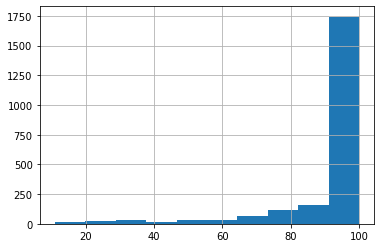

In [11]:
df['match_score'].hist()

In [13]:
f = open('results/matches.csv', mode='w')
f.write(df.to_csv(index=False))
f.close()